## Phasenet Download code

In [1]:
%%capture
!git clone https://github.com/AI4EPS/EQNet
!python -m pip install -r EQNet/requirements.txt

In [1]:
import os
import torch
import numpy as np
import h5py
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

2024-11-18 08:38:33.432182
2024-11-18 08:38:33.432182
{'dt': 0.002, 'nt': 15000, 'dx': 1.0209519863128662, 'nch': 1472, 'GL': 10.0, 'headers': {'AcquisitionDescription': b'', 'AcquisitionId': b'c5644e34-f9a9-5e3f-4a44-ed63f9e870ff', 'FacilityId': array([b'TBD'], dtype='|S3'), 'GaugeLength': 10.0, 'GaugeLength.uom': b'm', 'MaximumFrequency': 250.0, 'MaximumFrequency.uom': b'Hz', 'MeasurementStartTime': b'2024-11-18T00:38:33.432182+00:00', 'MinimumFrequency': 0.0, 'MinimumFrequency.uom': b'Hz', 'NumberOfLoci': 1472, 'PulseRate': 8000.0, 'PulseRate.uom': b'Hz', 'PulseWidth': 50.0, 'PulseWidth.uom': b'ns', 'ServiceCompanyName': b'Silixa', 'SpatialSamplingInterval': 1.0209519863128662, 'SpatialSamplingInterval.uom': b'm', 'StartLocusIndex': 0, 'TriggeredMeasurement': False, 'schemaVersion': b'2.1', 'uuid': b'264c6f84-2f28-4411-a7a0-c85bf9022070'}}


Text(0, 0.5, 'Time (s)')

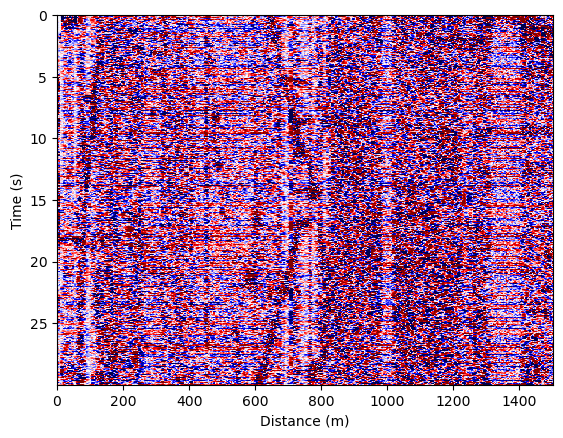

In [2]:
import DasPrep as dp
normalize = lambda x: (x - np.mean(x, axis=-1, keepdims=True)) / np.std(x, axis=-1, keepdims=True)
# h5_files = glob("data/*.h5")
# for file in h5_files:
file = f"/home/disk/disk01/wzm/EQNet/docs/data/testread.h5"
data = dp.read_das(file)
metadata = dp.read_das(file , metadata = True)
dt = metadata['dt']
dx = metadata['dx']
nx, nt = data.shape
x = np.arange(nx) * dx
t = np.arange(nt) * dt
print(metadata)
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

Text(0, 0.5, 'Time (s)')

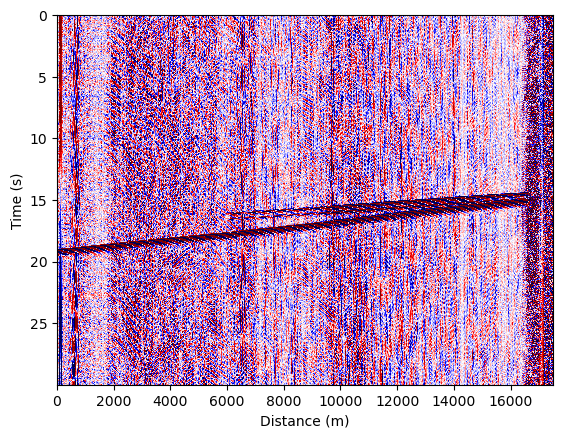

In [15]:
normalize = lambda x: (x - np.mean(x, axis=-1, keepdims=True)) / np.std(x, axis=-1, keepdims=True)
# h5_files = glob("data/*.h5")
# for file in h5_files:
file = f"data/DAS_20250423122330_20250423122400.h5"
with h5py.File(file, "r") as fp:
    data = fp["Acquisition/Raw[0]/RawData"][()]
    dt = 1/ fp["Acquisition/Raw[0]"].attrs["OutputDataRate"]

    dx = fp["Acquisition"].attrs["SpatialSamplingInterval"]
    nx, nt = data.shape
    x = np.arange(nx) * dx
    t = np.arange(nt) * dt
        
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")


## Run PhaseNet-DAS

In [2]:
ngpu = torch.cuda.device_count()
base_cmd = "/home/disk/disk01/wzm/EQNet/predict.py --model phasenet_das --data_list=files.txt  --data_path=/home/disk/disk01/wzm/EQNet/synthesisdata/noise --result_path ./results --format=h5  --batch_size 1 --workers 0 --system xilisa"

In [8]:
# with open("files.txt", "w") as f:
#     f.write(f"data/{event_id}.h5")

if ngpu == 0:
    cmd = f"python {base_cmd} --device cpu"
elif ngpu == 1:
    cmd = f"python {base_cmd}"
else:
    cmd = f"torchrun --nproc_per_node {ngpu} {base_cmd}"

print(cmd)
os.system(cmd)

python /home/disk/disk01/wzm/EQNet/predict.py --model phasenet_das --data_list=files.txt  --data_path=/home/disk/disk01/wzm/EQNet/synthesisdata/noise --result_path ./results --format=h5  --batch_size 1 --workers 0 --system xilisa


/home/wuzm/anaconda3/envs/base_archive/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Not using distributed mode
Namespace(model='phasenet_das', resume='', backbone='unet', phases=['P', 'S'], device='cuda', workers=0, batch_size=1, use_deterministic_algorithms=False, amp=False, world_size=1, dist_url='env://', data_path='/home/disk/disk01/wzm/EQNet/synthesisdata/noise', data_list='files.txt', hdf5_file=None, prefix='', format='h5', dataset='das', result_path='./results', plot_figure=False, min_prob=0.3, add_polarity=False, add_event=False, sampling_rate=100.0, highpass_filter=0.0, response_path=None, response_xml=None, subdir_level=0, cut_patch=False, nt=20480, nx=5120, resample_time=False, resample_space=False, system='xilisa', location=None, skip_existing=False, distributed=False)
Total samples: 1 files


Predicting: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


0

## Plot results

In [ ]:
event_id = "DAS_20250423123230_20250423123300"

picks = pd.read_csv(f"results/picks_phasenet_das/{event_id}.csv")

EmptyDataError: No columns to parse from file

Text(0, 0.5, 'Time (s)')

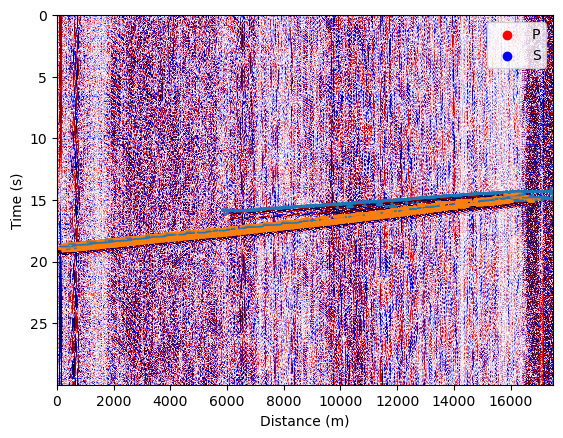

In [22]:
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
color = picks["phase_type"].map({"P": "C0", "S": "C1"})
plt.scatter(picks["channel_index"].values * dx, picks["phase_index"].values * dt, c=color, s=1)
plt.scatter([], [], c="r", label="P")
plt.scatter([], [], c="b", label="S")
plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

# pyocto  install   

In [5]:
!pip install pyocto pyarrow

In [8]:
import pyocto
import pandas as pd
import datetime
import os

In [9]:
result_dir = "./results/pyocto"
result_path = lambda x: os.path.join(result_dir, x)
station_csv = "das_location.txt"
event_id = "DAS_20250423122330_20250423122400 copy"

In [10]:
picks = pd.read_csv(f"results/picks_phasenet_das/{event_id}.csv")

picks['station_id'] = picks.apply(lambda x: 'CH-'+ str(x['channel_index']).zfill(6), axis=1)
picks['phase_amplitude'] = 200
picks.rename(columns={"station_id": "station", "phase_time": "time", "phase_type": "phase", "phase_score": "prob", "phase_amplitude": "amp"}, inplace=True)
print(picks.head(5))

stations = pd.read_csv(station_csv, sep=',',names=['longitude','latitude', 'elevation_m'])
stations.reset_index(inplace=True)
stations['station_id'] = stations.apply(lambda x: 'CH-'+ str(int(x['index'] )).zfill(6), axis=1)
stations['elevation_m'] = 10
stations.rename(columns={"station_id": "id", "elevation_m": "elevation"}, inplace=True)
print(stations.head(5))
stations= stations.iloc[0:1674:50] # 一千个通道需要比较长的时间，先考虑降采样，计算时间在6min左右
stations.to_csv(result_path("statons.csv"),index = False,sep=' ')
picks = picks[picks['station'].isin(stations['id'])]

velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)
associator = pyocto.OctoAssociator.from_area(
    lat=(29.95, 30.2),
    lon=(121.5, 121.95),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)
associator.transform_stations(stations)
picks["time"] = pd.to_datetime(picks["time"]).apply(lambda x: x.timestamp())
events, assignments = associator.associate(picks, stations)
associator.transform_events(events)
print(events)
if len(events) > 0:
    events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
    events.to_csv(result_path("associate_cat.csv"),index=False,sep=',',mode='w')
    associate_list = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
    associate_list.to_csv(result_path("associate_list.csv"),index = False,sep=',')

The required number of P picks per event (3) is lower than the number of stations with both P and S pick (4). The effective number of P picks required will be 4.
The required number of S picks per event (3) is lower than the number of stations with both P and S pick (4). The effective number of S picks required will be 4.


   channel_index  phase_index                     time   prob phase  \
0              0         1857  2025-04-23T12:23:48.570  0.396     S   
1              0         1894  2025-04-23T12:23:48.940  0.791     S   
2              1         1857  2025-04-23T12:23:48.570  0.393     S   
3              1         1895  2025-04-23T12:23:48.950  0.875     S   
4              2         1894  2025-04-23T12:23:48.940  0.931     S   

     station  amp  
0  CH-000000  200  
1  CH-000000  200  
2  CH-000001  200  
3  CH-000001  200  
4  CH-000002  200  
   index   longitude   latitude  elevation         id
0      0  121.823928  30.078215         10  CH-000000
1      1  121.823824  30.078219         10  CH-000001
2      2  121.823724  30.078198         10  CH-000002
3      3  121.823625  30.078171         10  CH-000003
4      4  121.823525  30.078144         10  CH-000004
   idx          time         x         y         z  picks   latitude  \
0    0  1.745411e+09 -6.108839 -6.489519  0.390625     58

# Velest

In [ ]:
#install 
!git clone  https://github.com/Dal-mzhang/LOC-FLOW
!cd LOC-FLOW/src
!python src/software_download.py

In [ ]:
run_dir = "results/synthesis_data/velest"
if not os.path.exists(run_dir):
    os.makedirs(run_dir)
phaseSA_select = run_dir+"/phaseSA_select.txt"
phaseSA_best_select = run_dir+"/phaseSA_best_select.txt"
# os.remove(phaseSA_select)
# os.remove(phaseSA_best_select)

channle = []
num = 0
# pyocto_events = pd.read_csv(result_path("associate_cat.csv"), parse_dates=["time"])
event_phase_sel =pd.read_csv(result_path("associate_list.csv"))
for time,grp in event_phase_sel.groupby('time'):
    num += 1
    # print(g.head(5))
    n_P_picks = len( grp.loc[grp['phase'] == 'P'].drop_duplicates())
    n_S_picks = len( grp.loc[grp['phase'] == 'S'].drop_duplicates())
    n_total_picks = len(grp)
    n_station =  len(grp)-  len( grp['station'].drop_duplicates())
    grp.loc[:,'station'] =[ int(i.split("-")[-1]) for i in  grp['station']]
    x,y,z,picks,latitude,longitude,depth = grp.loc[grp.index[0] , ['x' ,'y' , 'z','picks', 'latitude',  'longitude' ,'depth']]
    grp["time_pick"] = grp["time_pick"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc).__sub__(pd.to_datetime(time)).dt.total_seconds()
    with open(phaseSA_best_select,'a') as f:
        g = grp
        g = g.loc[g['prob'] > 0.4]
        if len(g)>0:
            f.write('# {}   {:.4f}   {:.4f}   {:.3f}  {:.2f}    {:.2f}    {:.2f}    {:.2f}      {} \n'.format(pd.to_datetime(time).strftime('%Y %m %d %H %M %S.%f')[:-3], latitude, longitude, depth , 0 ,0, 0, 0, str(num).zfill(6)))
            for idx, row in g.sort_values(by='prob',ascending=False).head(40).iterrows():

                f.write('{}   {:.4f} {:.4f} {}\n'.format(str(row['station']).zfill(5) , row['time_pick'] , row['prob'] , row['phase']))
                channle.append(str(row['station']).zfill(5))
    with open(phaseSA_select,'a') as f:
        g = grp
        f.write('# {}   {:.4f}   {:.4f}   {:.3f}  {:.2f}    {:.2f}    {:.2f}    {:.2f}      {} \n'.format(pd.to_datetime(time).strftime('%Y %m %d %H %M %S.%f')[:-3], latitude, longitude, depth , 0 ,0, 0, 0, str(num).zfill(6)))
        arr = np.linspace(0, len(g)-1, num= min( 500 , len(g)) ,  dtype=int)
        for idx, row in g.sort_values(by='station').iterrows():
            if idx in g.index[arr]:
                f.write('{}  {:.3f} 1 {}\n'.format(str(row['station']).zfill(5) , row['time_pick'], row['phase']))
                channle.append(str(row['station']).zfill(5))


stations = pd.read_csv(result_path("statons.csv"), sep='\s+')
stations['station_id'] = [ str(int(i.split('-')[-1])).zfill(5) for i in stations['id'] ]
stations = stations.loc[stations['station_id'].map(lambda x:x in channle) ]
stations['elevation_m'] = "1.00"
stations['HHZ'] = 'DPZ'
stations['net'] = 'XF'
stations.to_csv((run_dir+"/station.dat") , columns=["longitude", "latitude", "net", "station_id", "HHZ" ,"elevation_m"] , index=False, header=False , sep=' ' ,float_format='%.6f')
os.chdir("model/LOC-FLOW/location/VELEST")
command = "bash model/LOC-FLOW/location/VELEST/run_velest.sh  0 "
print(command)
os.system(command)
command = "cp model/LOC-FLOW/location/VELEST/new.cat   "+result_path("velest.cat")
print(command)
os.system(command)

In [ ]:
velest_events = pd.read_csv(result_path("velest.cat"),sep='\s+',header=None, names=['day','hour','minute','seconds','latitude' , 'longitude','depth','mag', 'stationgap' , 'res' , 'event_idx'])
velest_events['year'] = ['20'+str(i)[:2] for i in velest_events['day']]
velest_events['month'] = [str(i)[2:4] for i in velest_events['day']]
velest_events['day'] = [str(i)[4:] for i in velest_events['day']]
velest_events['time'] = pd.to_datetime(velest_events[['year','month' , 'day', 'hour','minute','seconds']] , utc = True)